In [1]:

# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import torchmetrics

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14



In [2]:
import torch
from torch import optim, cuda
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
from pathlib import Path
#import cv2
import os
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap

In [33]:
torch.manual_seed(48)
split_seed = 69

In [34]:
if torch.cuda.is_available():
    print('cuda')
    device = torch.device("cuda")
    use_cuda = True
else:
    print('cpu')
    device = torch.device("cpu")
    use_cuda = False

cuda


In [35]:
# define transformations that you wish to apply on image
# define transformations that you wish to apply on image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        #transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}





In [36]:
transf=data_transforms['validation']

In [37]:
#  Load the datasets with ImageFolder
image_datasets = {
    'train': 
    torchvision.datasets.ImageFolder(root='/data/plic_imaging/data/train3', transform=data_transforms['train']),
    'validation': 
    torchvision.datasets.ImageFolder(root='/data/plic_imaging/data/test3',  transform=data_transforms['validation'])
}

In [38]:
test_data=image_datasets['validation']

Interpretability: Captum

In [39]:
from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import InputXGradient
from captum.attr import GuidedBackprop
from captum.attr import GradientShap
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [42]:
n_img = 10

In [41]:
def unnorm_tensor(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    '''
    Unnormalize an image Tensor
    '''
   
    mean = torch.Tensor(mean)
    std = torch.Tensor(std)
    unnorm = transforms.Normalize((-mean/std).tolist(), (1.0/std).tolist())
    return unnorm(img)

In [43]:
# color map for displaying attributions
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                [(0, '#ffffff'),
                                                (0.25, '#000000'),
                                                (1, '#000000')], N=256)

In [44]:
# get test filenames and labels
fn_test = [item[0] for item in test_data.imgs]
y_test = test_data.targets
# random subsample n_img test images, with stratification
_, fn, _, y = train_test_split(fn_test, y_test, test_size=n_img, stratify=y_test, random_state=split_seed)

In [45]:
# define model, load weights
net = models.resnet50(pretrained=True)
net.load_state_dict(torch.load('/home/trigo/models/pytorch/weights6.h5'), strict=False)


_IncompatibleKeys(missing_keys=['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.conv3.weight', 'layer1.1.bn3.weight', 'layer1.1.bn3.bias', 'layer1.1.bn3.runni

In [46]:
if torch.cuda.is_available():
    net.cuda()

In [47]:
# output path
outdir = Path(f'output/subsampling_{n_img}')

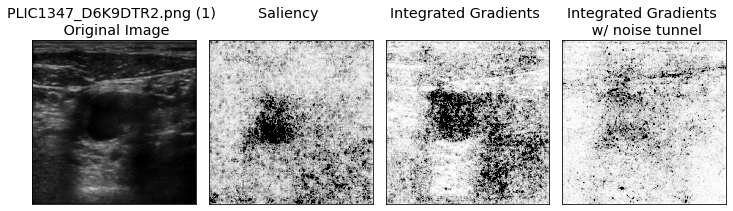

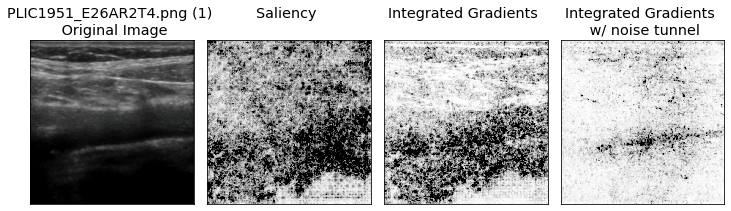

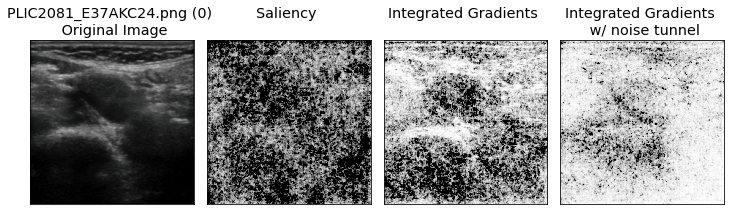

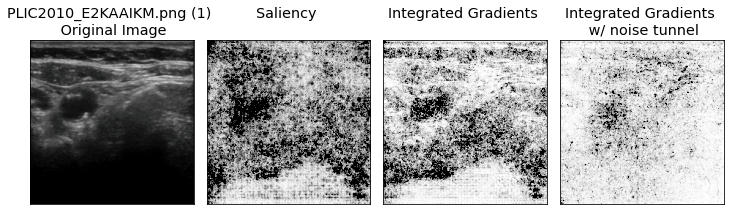

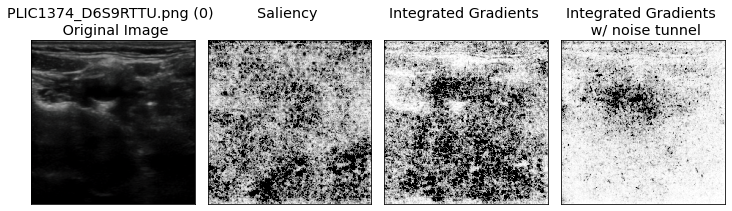

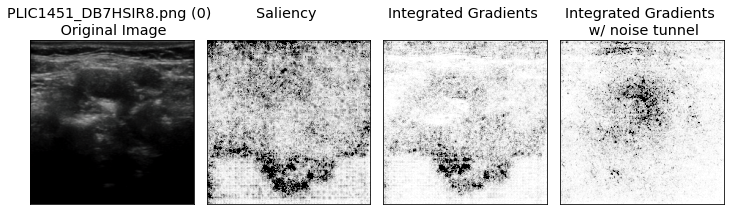

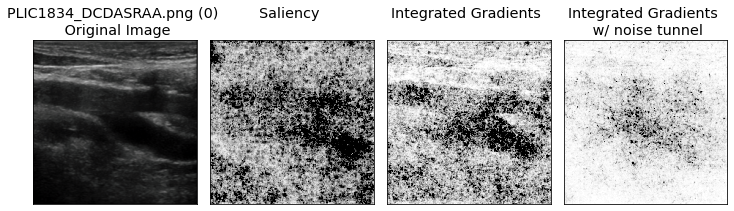

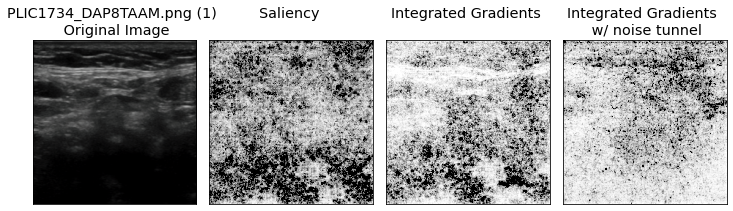

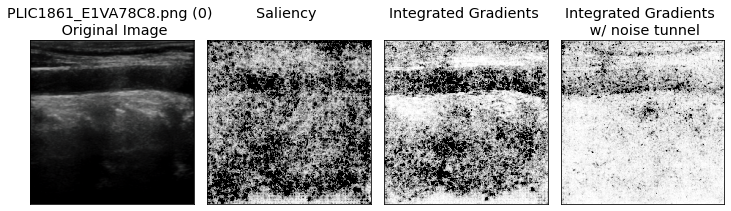

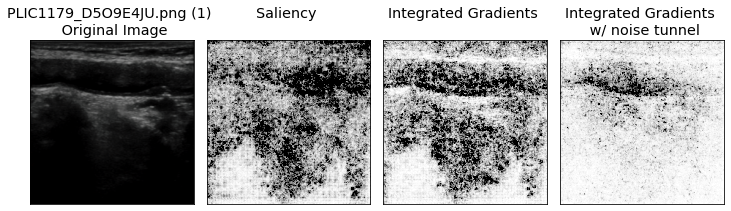

In [49]:
# loop over the selected test images, predict, compute attributions
for img_idx in range(n_img):
    img_tensor = transf(Image.open(fn[img_idx]))
    input = img_tensor.unsqueeze(0)
    input.requires_grad = True
    labels = y[img_idx]
  
    
    net.eval()
    
    with torch.no_grad():
        output = net(input.to(device))
    _, predicted = torch.max(output, 1)
    
    #General Attribution methods that will help us to get an understanding of what the model is looking for when making a certain prediction.

    saliency = Saliency(net)
    grads = saliency.attribute(input.to(device), target=labels)
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    # Create IntegratedGradients object and get attributes
    ig = IntegratedGradients(net)
    net.zero_grad()
    noise_tunnel = NoiseTunnel(ig)
    attr_ig = ig.attribute(input.to(device), target=labels, n_steps=50, internal_batch_size=1)
    attr_ig_nt = noise_tunnel.attribute(input.to(device), n_steps=10, nt_type='smoothgrad_sq', target=labels)
    attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    
    original_image = np.transpose(unnorm_tensor(img_tensor).detach().numpy(), (1, 2, 0))
    image_name = os.path.basename(fn[img_idx])
    base_title = f'{image_name} ({labels})'
    
    outfn = outdir / f'seed{split_seed}_xai_{os.path.splitext(image_name)[0]}_class{labels}.png'
    
    plt_fig = plt.figure(figsize=(10, 7))
    plt_axis = plt_fig.subplots(1, 4)
    plt.rcParams.update({'font.size': 12})
    
    _ = viz.visualize_image_attr(None, original_image,
                                 method="original_image", title=f"{base_title} \n Original Image",
                                 plt_fig_axis=(plt_fig, plt_axis[0]),
                                 use_pyplot=False)

    _ = viz.visualize_image_attr(grads, original_image, method="heat_map", cmap=default_cmap, sign="absolute_value",
                                 show_colorbar=False, title="Saliency \n",
                                 plt_fig_axis=(plt_fig, plt_axis[1]),
                                 use_pyplot=False)
    
    _ = viz.visualize_image_attr(attr_ig, original_image, method="heat_map", cmap=default_cmap, sign="absolute_value",
                                 show_colorbar=False, title="Integrated Gradients \n",
                                 plt_fig_axis=(plt_fig, plt_axis[2]),
                                 use_pyplot=False)
                                   

    _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="heat_map", cmap=default_cmap, sign="absolute_value",
                                 show_colorbar=False, title="Integrated Gradients \n w/ noise tunnel",
                                 plt_fig_axis=(plt_fig, plt_axis[3]),
                                 use_pyplot=False)
    
    
    plt_fig.tight_layout()
    plt.show()
    

    torch.cuda.empty_cache()
    

In [24]:
plt_fig.savefig("captum1_dist.png", format='png', dpi=400, bbox_inches = 'tight', facecolor='w')